# Simulation of HPL on Dahu

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_result(name):
    archive = zipfile.ZipFile(name)
    return pandas.read_csv(io.BytesIO(archive.read('results.csv')))

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    info = get_yaml(name, 'info.yaml')
    installfile = info['installfile']
    result['model'] = installfile[8:10]  # filename of the form 'install_A1.yaml', so we get the 'A1'
    install_options = get_yaml(name, installfile)
    result['stochastic_cpu'] = install_options['stochastic_cpu']
    result['polynomial_dgemm'] = install_options['polynomial_dgemm']
    result['stochastic_network'] = install_options['stochastic_network']
    return result

simulation_dir = 'paper_sc19/performance/3/'
simulation_files = [simulation_dir + f for f in os.listdir(simulation_dir)]

reality_files = [
    '../hpl/grenoble_2018-10-10_1811810.zip',
    '../hpl/grenoble_2018-10-10_1811847.zip',
]
reality_files_new = [
    '../hpl/grenoble_2019-03-15_1855885.zip',
    '../hpl/grenoble_2019-03-18_1856059.zip',
]
dfsim = pandas.concat([read_sim_result(f) for f in simulation_files])
dfreal = pandas.concat([read_result(f) for f in reality_files])
dfreal_new = pandas.concat([read_result(f) for f in reality_files_new])
dfsim['mode'] = 'simulation'
dfreal['mode'] = 'reality:old'
dfreal_new['mode'] = 'reality:new'
df = pandas.concat([dfsim, dfreal, dfreal_new])
sizes = set(dfsim.matrix_size) & set(dfreal.matrix_size)
df = df[df.matrix_size.isin(sizes)]
df.head()

,application_time,bcast,block_size,cpu_utilization,depth,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept,gflops,...,residual,rfact,simulation_time,stochastic_cpu,stochastic_network,swap,sys_time,thread_per_process,time,usr_time
0,635.993,2,128,0.99,1,42.0,42.0,42.0,42.0,20480.0,...,NaN,2,5280.18,True,True,0,591.73,1,63.58,4687.79
1,1144.770,2,128,0.99,1,42.0,42.0,42.0,42.0,23560.0,...,NaN,2,10011.60,True,True,0,1644.64,1,442.21,8364.43
2,2286.010,2,128,0.99,1,42.0,42.0,42.0,42.0,24640.0,...,NaN,2,20425.10,True,True,0,4922.23,1,2465.98,15498.95
0,470.372,2,128,0.99,1,42.0,42.0,42.0,42.0,19800.0,...,NaN,2,3692.89,True,True,0,322.89,1,33.67,3369.37
1,885.350,2,128,0.99,1,42.0,42.0,42.0,42.0,22760.0,...,NaN,2,7269.14,True,True,0,1030.56,1,234.35,6236.36


### Checking the parameters

In [2]:
dfsim[['dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept']].drop_duplicates()

,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept
0,42.0,42.0,42.0,42.0


In [3]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'platform', 'model',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,process_per_node,pfact,proc_q,depth,mem_align,rfact,thread_per_process,swap,block_size,bcast,proc_p
0,32,1,32,1,8,2,1,0,128,2,32


In [4]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files] # I changed the platform in this new simulation, calls to SMPI_Wtime now do not take time
# platforms = [zipfile.ZipFile(f).read('dahu.xml').decode('ascii') for f in (simulation_files + simulation_files_old)]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460505;15831:5.716405752533658;33956:12.659099698925065;64000:0.9867951082730274"/>
        <prop id="smpi/lat-factor" value="0:1.2162964660682605;8133:19.230103984475342;15831:18.285606440676755;33956:51.6103738900493;64000:129.24904864615127"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="0-31" speed="1" core="32" bw="12.5GBps" lat="0.05us" loopback_bw="18.348422228142745GBps" loopback_lat="0.0us"/>
    </AS>
</platform>

```

### Checking the patch in the new simulation

In [5]:
patches = {}
for archive in simulation_files:
    installfile = get_yaml(archive, 'info.yaml')['installfile']
    install_options = get_yaml(archive, installfile)
    stochastic_cpu = install_options['stochastic_cpu']
    polynomial_dgemm = install_options['polynomial_dgemm']
    repos = get_yaml(archive, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    try:
        patches[(stochastic_cpu, polynomial_dgemm)].add(hpl[0]['patch'])
    except KeyError:
        patches[(stochastic_cpu, polynomial_dgemm)] = {(hpl[0]['patch'])}
for (stochastic_cpu, polynomial_dgemm), patch in patches.items():
    assert len(patch) == 1
    display(Markdown('### stochastic_cpu=%s  |  polynomial_dgemm=%s' % (stochastic_cpu, polynomial_dgemm)))
    display(Markdown('```diff\n%s\n```' % patch.pop()))

### stochastic_cpu=True  |  polynomial_dgemm=True

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 
```

### Comparing the simulation with the real execution

In [6]:
dfsim[['stochastic_cpu', 'polynomial_dgemm', 'stochastic_network']].drop_duplicates()

,stochastic_cpu,polynomial_dgemm,stochastic_network
0,True,True,True


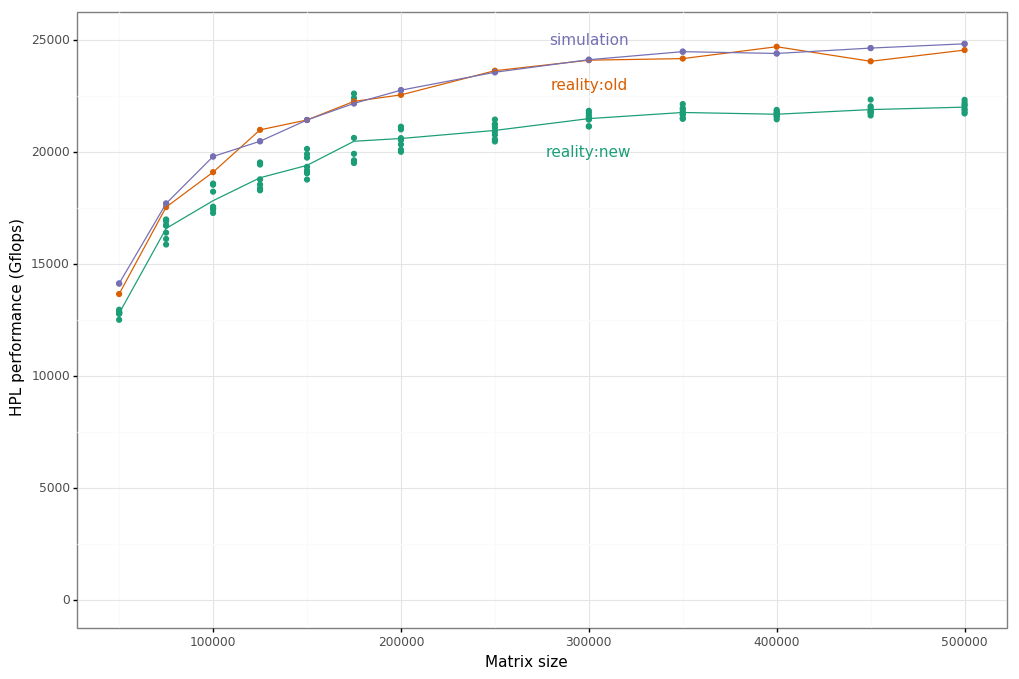

<ggplot: (8753119338816)>

In [7]:
import numpy

# Computing the coordinates for the text...
tmp = pandas.DataFrame({
    'mode': ['reality:old', 'reality:new', 'simulation'],
    'matrix_size': [3e5]*3,
    'gflops': [2.3e4, 2e4, 2.5e4]
})

plot = ggplot(df, aes(x='matrix_size', y='gflops', color='mode')) + theme_bw() + expand_limits(y=0)
plot = plot + geom_point() + stat_summary(fun_y = numpy.mean, geom='line')
plot = plot + scale_color_brewer(type='qual', palette='Dark2', guide=False)
plot = plot + geom_text(tmp, aes(x = 'matrix_size', y = 'gflops', color = 'mode', label='mode'))
plot = plot + xlab('Matrix size') + ylab('HPL performance (Gflops)') + labs(color='Model')
plot

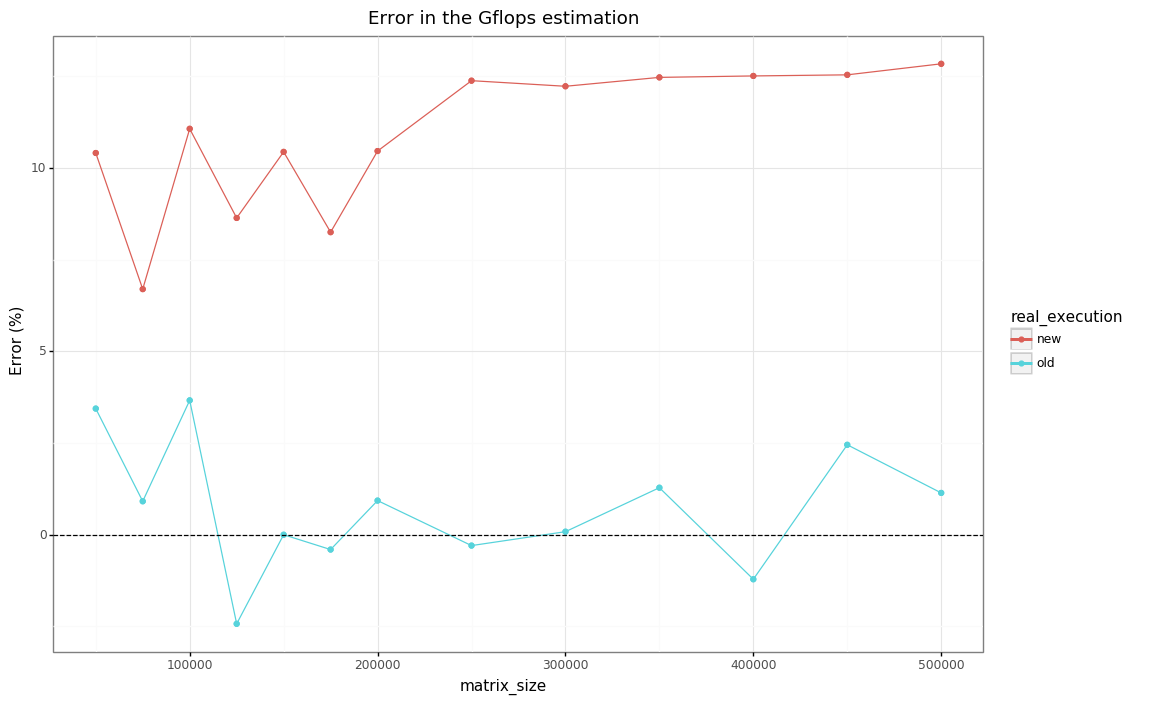

<ggplot: (8753118711770)>


In [8]:
errors = []
for tmp_real in [dfreal, dfreal_new]:
    mode = tmp_real['mode'].unique()
    tmp_real = tmp_real.groupby('matrix_size')[['gflops', 'time']].mean().reset_index()
    tmp = dfsim.set_index('matrix_size').join(tmp_real.set_index('matrix_size'), rsuffix='_real').reset_index()
    tmp['error'] = (tmp.gflops - tmp.gflops_real) / tmp.gflops_real * 100
    tmp = tmp[~tmp.error.isna()]
    assert len(mode) == 1
    tmp['real_execution'] = list(mode)[0][8:]
    errors.append(tmp)
errors = pandas.concat(errors)
plot = ggplot(errors, aes(x='matrix_size', y='error', color='real_execution')) + geom_line() + geom_point() + ylab('Error (%)')
plot = plot + ggtitle('Error in the Gflops estimation' % mode) + theme_bw()
plot = plot + geom_hline(yintercept=0, linetype='dashed')
print(plot)